In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
import pylab
from matplotlib import cm
import seaborn as sns
from statsmodels.compat import lzip

In [2]:
#cargamos los datos
forest = pd.read_csv('forest_data.txt', delim_whitespace=True)
forest.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.36
1,1,4,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.43
2,2,5,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.47
3,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.55
4,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.61


# Análisis Exploratorio de los Datos

In [3]:
forest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       270 non-null    int64  
 1   Y       270 non-null    int64  
 2   month   270 non-null    object 
 3   day     270 non-null    object 
 4   FFMC    270 non-null    float64
 5   DMC     270 non-null    float64
 6   DC      270 non-null    float64
 7   ISI     270 non-null    float64
 8   temp    270 non-null    float64
 9   RH      270 non-null    int64  
 10  wind    270 non-null    float64
 11  rain    270 non-null    float64
 12  area    270 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 27.5+ KB


array([[<AxesSubplot:title={'center':'X'}>,
        <AxesSubplot:title={'center':'Y'}>,
        <AxesSubplot:title={'center':'FFMC'}>],
       [<AxesSubplot:title={'center':'DMC'}>,
        <AxesSubplot:title={'center':'DC'}>,
        <AxesSubplot:title={'center':'ISI'}>],
       [<AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'RH'}>,
        <AxesSubplot:title={'center':'wind'}>],
       [<AxesSubplot:title={'center':'rain'}>,
        <AxesSubplot:title={'center':'area'}>, <AxesSubplot:>]],
      dtype=object)

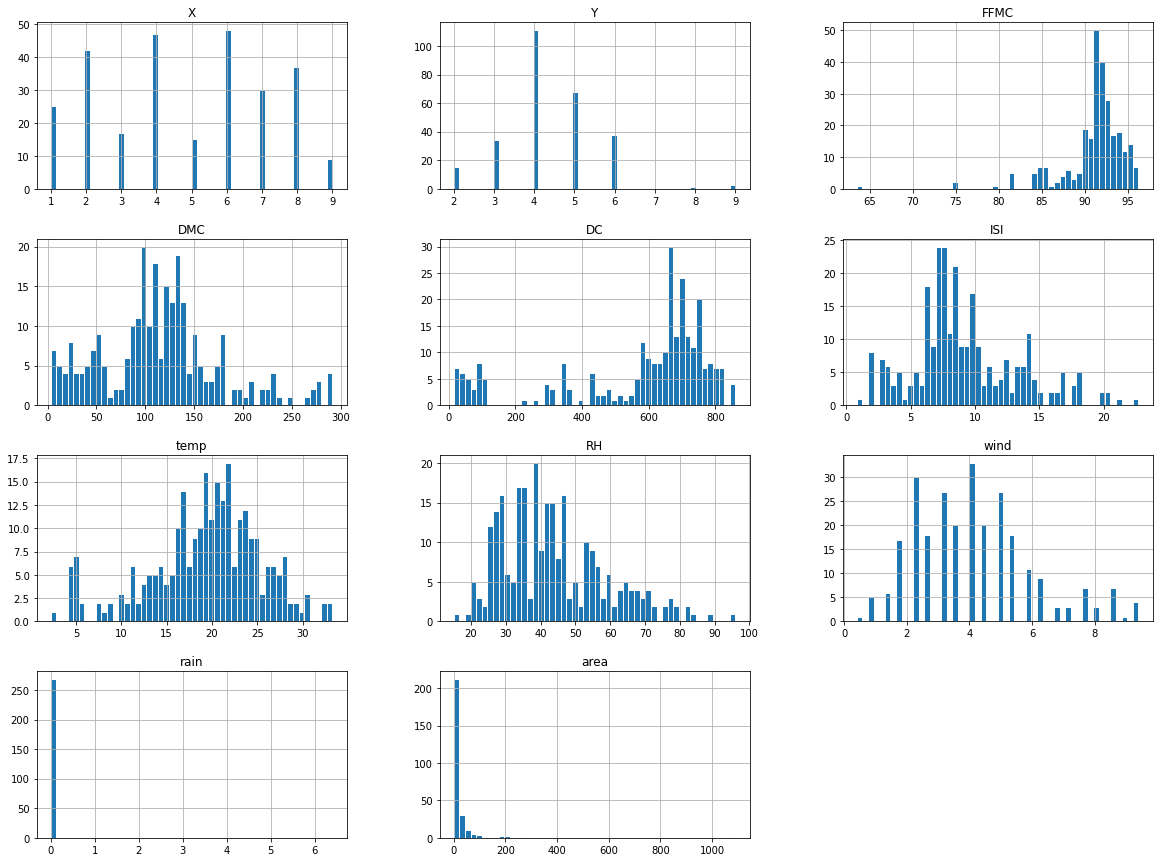

In [4]:
forest.hist(bins=50, figsize=(20,15), ec='w')

Vemos que hay valores atípicos en las variables FFMC e ISI. Por otro lado, parece que la variables DC es bimodal, mientras que temp y RH tiene colas muy pesadas. Veamos si podemos eliminar algunos outliers

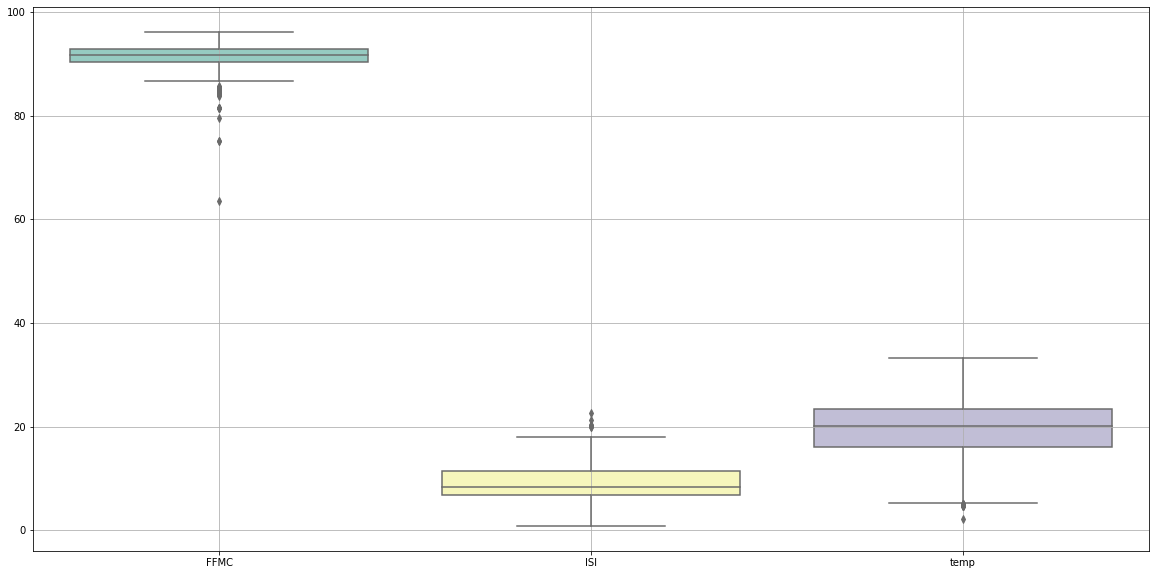

In [5]:
ffmc = forest['FFMC']
isi = forest['ISI']
temp = forest['temp']
area = forest['area']

#hacemos un boxplot
plt.figure(figsize=(20,10))
sns.boxplot(data=forest[['FFMC', 'ISI', 'temp']], palette='Set3')
plt.grid()
plt.show()

Vamos a eliminar los outliers, los cuales son los puntos que salen de los bigotes de las cajas ya que están a una distancia mayor de 1.5 veces el rango intercuartil.

- Para la varible FFMC eliminaremos las observaciones tales que valgan menos de 83
- Para ISI descaratmos aquellas que valgan más de 18
- Para temp las que valen menos de 5

In [6]:
forest = forest.drop(forest[forest['FFMC'] <= 83].index)
forest = forest.drop(forest[forest['ISI'] >= 30].index)
forest = forest.drop(forest[forest['temp'] <= 5].index)


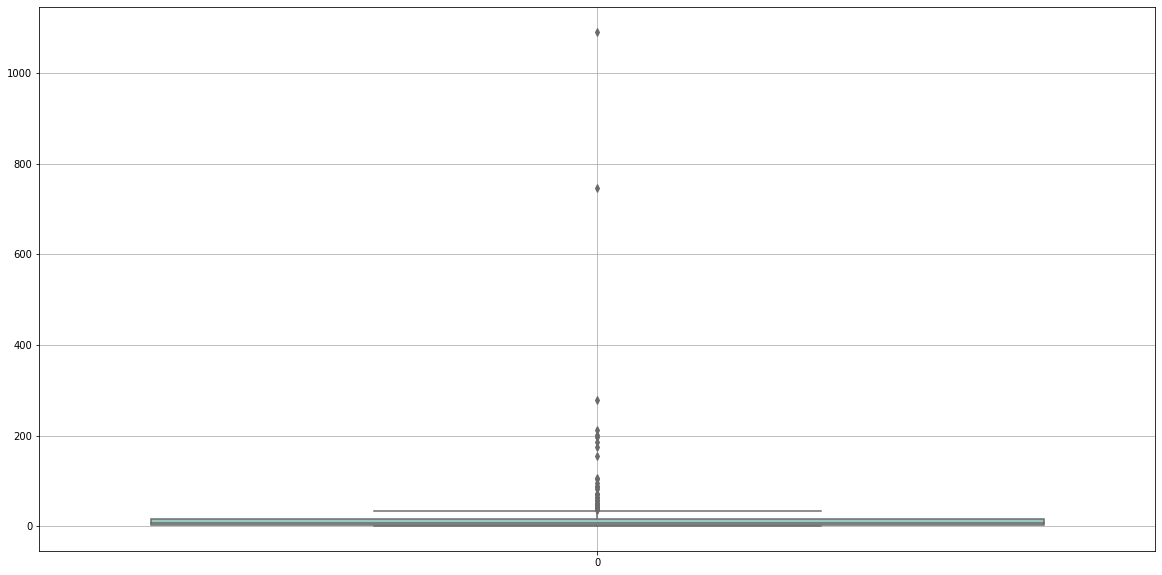

In [7]:
#ahora con el area
plt.figure(figsize=(20,10))
sns.boxplot(data=forest['area'], palette='Set3')
plt.grid()
plt.show()

In [8]:
#eliminamos los outliers
forest = forest.drop(forest[forest['area'] >= 150].index)

# Procesamiendo de los datos

In [9]:
#pasamos las variables categóricas a dummies
forest = pd.get_dummies(forest, columns=['month', 'day'], drop_first=True)
forest.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_mar,month_may,month_oct,month_sep,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,9,9,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,...,0,0,0,0,0,0,0,0,1,0
1,1,4,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,...,0,0,0,1,0,0,0,0,1,0
2,2,5,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,...,0,0,0,1,1,0,0,0,0,0
3,1,2,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,...,0,0,0,0,0,0,0,0,0,1
4,8,6,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Dividimos los datos entre la variable respuesta y las explicativas
X = forest.drop('area', axis=1)
y = forest['area']

#agregamos la columna de unos a la matriz X
X_cons = sm.add_constant(X)

# Creación del modelo

Queremos responder la pregunta de si se puede explicar el área quemada del bosque como una función lineal de las variables dadas y si es así, cuales de ellas son más relevantes? 

In [11]:
#usamos regresion lineal multiple
model = sm.GLS(y, X_cons).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.148
Model:                            GLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     1.533
Date:                Sun, 04 Jun 2023   Prob (F-statistic):             0.0561
Time:                        20:14:02   Log-Likelihood:                -1057.9
No. Observations:                 246   AIC:                             2168.
Df Residuals:                     220   BIC:                             2259.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.6933     86.210      0.194      0.847    -153.211     186.597
X              1.0825      0.613      1.765      0.079      -0.126       2.291
Y             -1.5655      1.280     -1.223      0.223      -4.088       0.958
FFMC           0.0706      0.954      0.074      0.941      -1.810       1.951
DMC            0.1228      0.039      3.166      0.002       0.046       0.199
DC            -0.0981      0.027     -3.601      0.000      -0.152      -0.044
ISI           -0.3072      0.533     -0.577      0.565      -1.357       0.742
temp           0.6549      0.483      1.356      0.177      -0.297       1.607
RH            -0.0138      0.140     -0.099      0.922      -0.289       0.262
wind           0.5384      0.780      0.690      0.491      -0.999       2.075
rain          -1.3042      3.092     -0.422      0.674      -7.397       4.789
month_aug     16.6778     19.945      0.836      0.404     -22.630      55.986
month_dec     15.5993     20.130      0.775      0.439     -24.072      55.271
month_feb    -12.3174     15.577     -0.791      0.430     -43.016      18.382
month_jul      1.5995     17.691      0.090      0.928     -33.267      36.466
month_jun     -4.6261     16.735     -0.276      0.782     -37.608      28.356
month_mar    -16.0459     14.223     -1.128      0.260     -44.076      11.984
month_may      8.3034     23.757      0.350      0.727     -38.517      55.124
month_oct     47.6630     23.471      2.031      0.043       1.407      93.919
month_sep     37.9858     22.134      1.716      0.088      -5.637      81.608
day_mon       -1.6512      4.749     -0.348      0.728     -11.011       7.709
day_sat        3.5298      4.469      0.790      0.430      -5.277      12.337
day_sun        4.8071      4.367      1.101      0.272      -3.799      13.413
day_thu       -1.2608      4.893     -0.258      0.797     -10.904       8.383
day_tue        8.4414      4.607      1.832      0.068      -0.637      17.520
day_wed        3.8804      4.756      0.816      0.415      -5.493      13.254
==============================================================================
Omnibus:                      110.064   Durbin-Watson:                   0.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              366.970
Skew:                           1.963   Prob(JB):                     2.06e-80
Kurtosis:                       7.515   Cond. No.                     4.64e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.64e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Vemos que el modelo tiene un valor muy bajo de $R^2$ ajustada. Procedemos a hacer la verificación de la regresión.

# Verificación de la Regresión

In [12]:
#error estandar
SE = np.sqrt(model.ssr / (forest.shape[0] - forest.shape[1] - 1 ))
print('El error estandar es: ', SE)
print('El valor de R2 ajustada es: ', model.rsquared_adj)
print('El p-valor de la estadística F es: ', model.f_pvalue)

El error estandar es:  18.910274671850587
El valor de R2 ajustada es:  0.05157984272109495
El p-valor de la estadística F es:  0.05607393963672692


El error estandar es un valor grande por lo que las observaciones están muy lejos de los valores estimados. Por otro lado, el valor de la $R^2$ ajustadad es practicamente cero, lo cual indica que nuestro modelo es pésimo. Finalmente, como el $p-value$ es casi 1, entonces no rechazamos $H_0$ la cual es la hipótesis de que no hay variables significativas.

En conclusión, tenemos un mal modelo. Lo siguiente que podemos hacer es el análisis de residuales para ver si es que hay alguno que no se cumple y como arreglarlo con el objetivo de mejorar el modelo.

# Análisis de Residuales

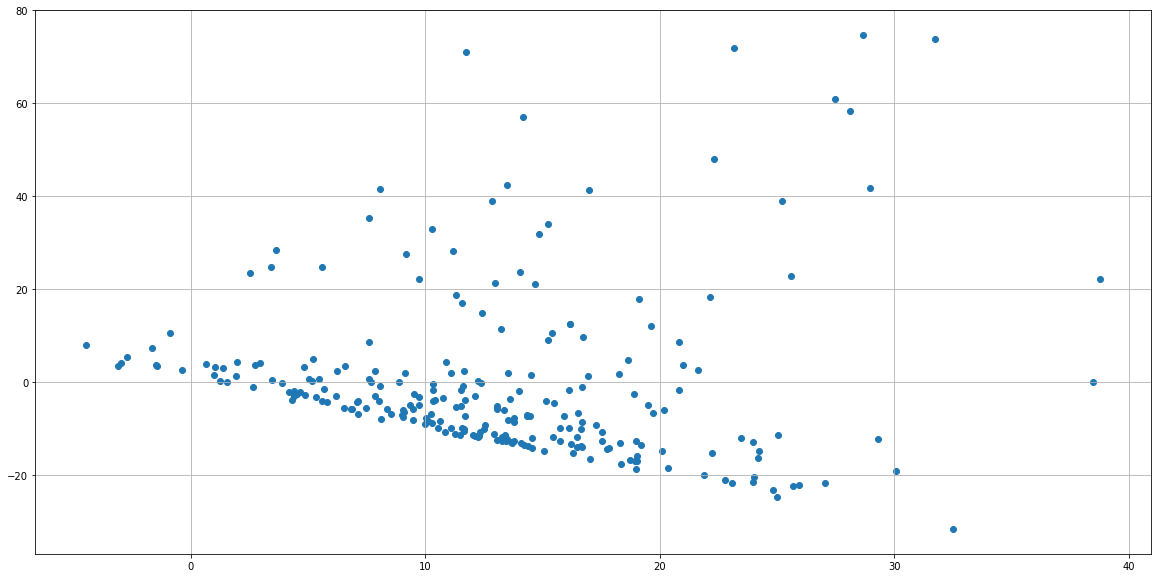

In [13]:
#Homocedasticidad 
plt.figure(figsize=(20,10))
plt.scatter(np.matmul(model.model.exog, model.params), model.resid)
plt.grid()


In [14]:
#prueba de Goldfeld-Quandt

result = sm.stats.diagnostic.het_goldfeldquandt(model.model.endog, model.model.exog, alternative="two-sided")

if result[1] > 0.05:
    print("No rechazamos H_0: la varianza es constante\n")
else:
    print("Rechazamos H_0: la varianza no es constante\n")


No rechazamos H_0: la varianza es constante



Notamos que la varianza no es constante, por lo que una idea es hacer una transformación a la variable respuesta para obtener la homocedasticidad

In [15]:
#aplicamos raiz, logaritmo y cuadrado a la variable respuesta
y_sqrt = np.sqrt(y)
y_log = np.log(y)
y_cuad = np.power(y, 2)

# Dividimos los datos entre la variable respuesta y las explicativas
X = forest.drop('area', axis=1)
y = forest['area']

#agregamos la columna de unos a la matriz X
X_cons = sm.add_constant(X)

#usamos regresion lineal multiple
model_sqrt = sm.GLS(y_sqrt, X_cons).fit()
model_log = sm.GLS(y_log, X_cons).fit()
model_cuad = sm.GLS(y_cuad, X_cons).fit()

#imprimimos los resultados
print('Modelo con variable respuesta transformada con raiz cuadrada')
print(model_sqrt.summary())
print('Modelo con variable respuesta transformada con logaritmo')
print(model_log.summary())
print('Modelo con variable respuesta transformada con cuadrado')
print(model_cuad.summary())


Modelo con variable respuesta transformada con raiz cuadrada
                            GLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.148
Model:                            GLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     1.532
Date:                Sun, 04 Jun 2023   Prob (F-statistic):             0.0563
Time:                        20:14:03   Log-Likelihood:                -512.35
No. Observations:                 246   AIC:                             1077.
Df Residuals:                     220   BIC:                             1168.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

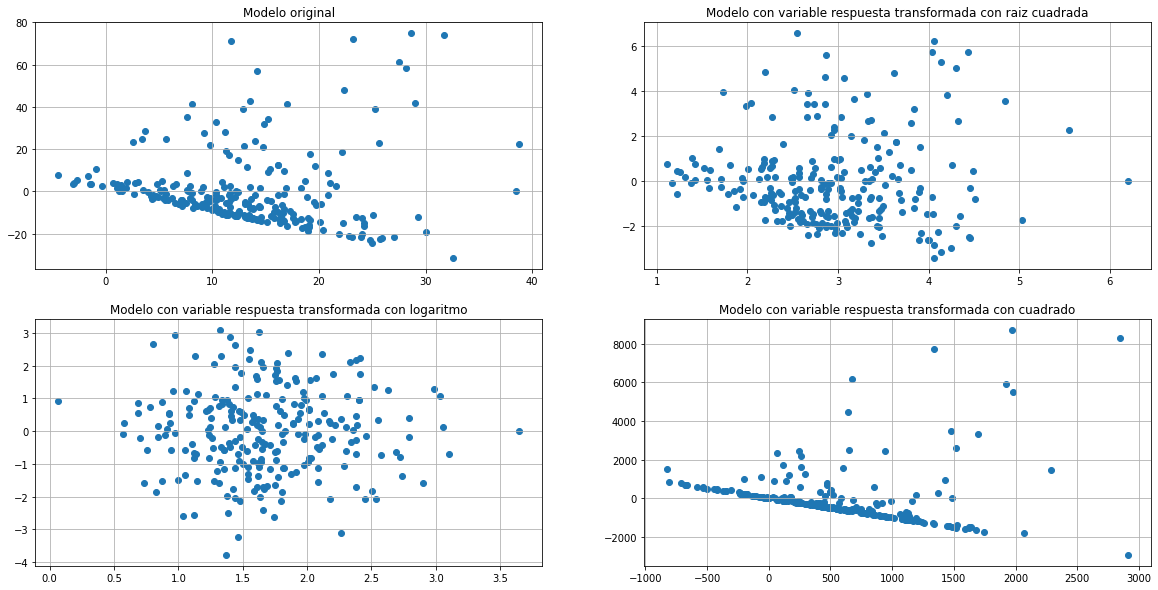

In [16]:
#hacemos un grafico de los residuos
models = [model, model_sqrt, model_log, model_cuad]
titles = ['Modelo original', 'Modelo con variable respuesta transformada con raiz cuadrada', 'Modelo con variable respuesta transformada con logaritmo', 'Modelo con variable respuesta transformada con cuadrado']

plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.scatter(np.matmul(models[i].model.exog, models[i].params), models[i].resid)
    plt.title(titles[i])
    plt.grid()

In [17]:
#Prueba de Goldfeld-Quandt
for i in range(4):
    print(titles[i])
    result = sm.stats.diagnostic.het_goldfeldquandt(models[i].model.endog, models[i].model.exog, alternative="two-sided")
    print(f'El p-valor de la prueba es: {result[1]}')
    if result[1] > 0.05:
        print("No rechazamos H_0: la varianza es constante")
    else:
        print("Rechazamos H_0: la varianza no es constante")
    print('--------------------------------------------------\n')

Modelo original
El p-valor de la prueba es: 0.12212444374042682
No rechazamos H_0: la varianza es constante
--------------------------------------------------

Modelo con variable respuesta transformada con raiz cuadrada
El p-valor de la prueba es: 0.25549715327999695
No rechazamos H_0: la varianza es constante
--------------------------------------------------

Modelo con variable respuesta transformada con logaritmo
El p-valor de la prueba es: 0.06390017331007343
No rechazamos H_0: la varianza es constante
--------------------------------------------------

Modelo con variable respuesta transformada con cuadrado
El p-valor de la prueba es: 0.0001429773196099537
Rechazamos H_0: la varianza no es constante
--------------------------------------------------



Notamos que los modelos de la raíz cuadrada y el modelo con el logaritmo son los unicos que tienen varianza consante, por lo que son los unicos que vamos a considerar

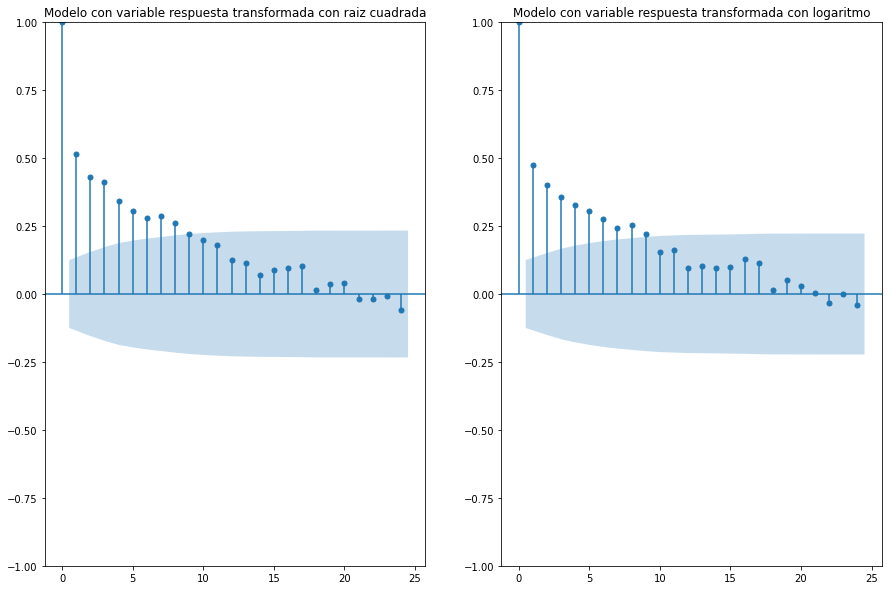

In [18]:
modelos = [model_sqrt, model_log]
titulos = ['Modelo con variable respuesta transformada con raiz cuadrada', 'Modelo con variable respuesta transformada con logaritmo']

#prueba de correlacion
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 10)

for i in range(2):
    plot_acf(modelos[i].resid, ax=ax[i], title=titulos[i])


Es claro que ninguno de los modelos considerados cumple que no haya correlación. 

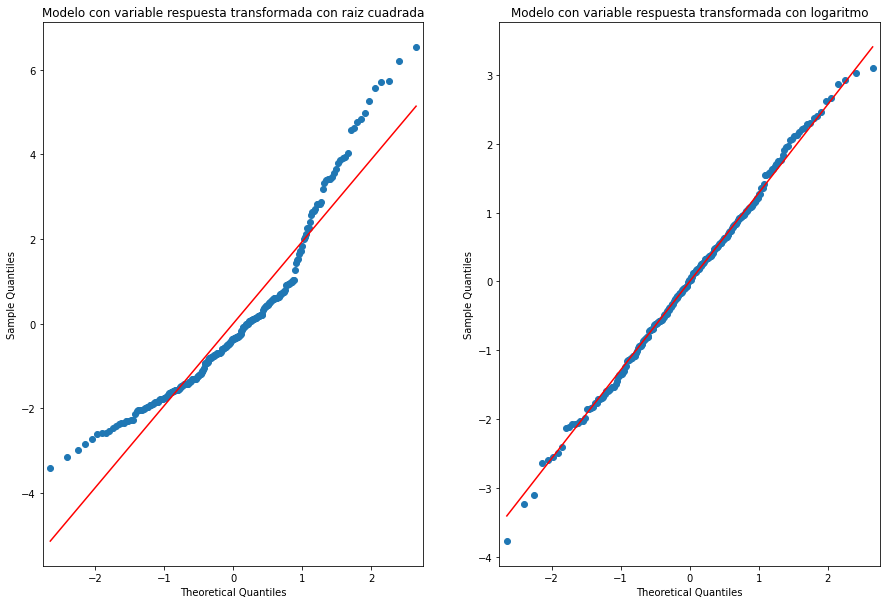

In [19]:
#normalidad de los residuos usando qqplot
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 10)

for i in range(2):
    sm.qqplot(modelos[i].resid, line='s', ax=ax[i])
    ax[i].set_title(titulos[i])

In [20]:
#usando shapiro
for i in range(2):
    print(titulos[i])
    print(f'El p-valor de la prueba es: {stats.shapiro(modelos[i].resid)[1]}')
    if stats.shapiro(modelos[i].resid)[1] > 0.05:
        print("No rechazamos H_0: los residuos tienen distribución normal")
    else:
        print("Rechazamos H_0: los residuos no tienen distribución normal")
    print('--------------------------------------------------\n')

Modelo con variable respuesta transformada con raiz cuadrada
El p-valor de la prueba es: 9.038922388349135e-11
Rechazamos H_0: los residuos no tienen distribución normal
--------------------------------------------------

Modelo con variable respuesta transformada con logaritmo
El p-valor de la prueba es: 0.88482266664505
No rechazamos H_0: los residuos tienen distribución normal
--------------------------------------------------



El modelo que más supuestos cumple es el de la transformación con el logaritmo natural, de hecho lo único que no cumple es la correlación de los errores

Veamos qué variables podemos quitar haciendo backward stepwise selection.

In [21]:
model_log.pvalues

const        0.356245
X            0.437276
Y            0.437136
FFMC         0.183407
DMC          0.002033
DC           0.041843
ISI          0.666834
temp         0.706677
RH           0.881114
wind         0.863684
rain         0.858616
month_aug    0.770227
month_dec    0.309817
month_feb    0.973186
month_jul    0.529962
month_jun    0.466048
month_mar    0.529365
month_may    0.529243
month_oct    0.147273
month_sep    0.573904
day_mon      0.680161
day_sat      0.270906
day_sun      0.358786
day_thu      0.763850
day_tue      0.212984
day_wed      0.907559
dtype: float64

Las variables que no pasaron la prueba $t$, es decir, que su coeficiente es cero son:

- DCM
- DC
- month_oct
- day_sat

Procedemos a eliminar dichas variables y ver el desempeño del nuevo modelo

In [22]:
#procedemos a eliminar dichas variables
X = forest.drop(['area', 'DMC', 'DC', 'month_oct', 'day_sat'], axis=1)
y_log = np.log(forest['area'])

#agregamos la columna de unos a la matriz X
X_cons = sm.add_constant(X)

#usamos regresion lineal multiple
model_log_mod = sm.GLS(y_log, X_cons).fit()
model_log_mod.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.104
Model:                            GLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.232
Date:                Sun, 04 Jun 2023   Prob (F-statistic):              0.226
Time:                        20:14:05   Log-Likelihood:                -417.25
No. Observations:                 246   AIC:                             878.5
Df Residuals:                     224   BIC:                             955.6
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.9292      6.149     -1.452      0.148     -21.047       3.189
X              0.0219      0.044      0.492      0.623      -0.066       0.110
Y             -0.0381      0.093     -0.411      0.682      -0.221       0.144
FFMC           0.1243      0.069      1.802      0.073      -0.012       0.260
ISI           -0.0412      0.038     -1.093      0.276      -0.116       0.033
temp           0.0329      0.034      0.964      0.336      -0.034       0.100
RH             0.0081      0.010      0.819      0.414      -0.011       0.028
wind           0.0246      0.056      0.438      0.662      -0.086       0.135
rain          -0.0149      0.226     -0.066      0.947      -0.460       0.430
month_aug     -1.8745      0.621     -3.018      0.003      -3.098      -0.651
month_dec      0.3676      1.056      0.348      0.728      -1.714       2.449
month_feb     -0.1090      0.795     -0.137      0.891      -1.676       1.458
month_jul     -1.8968      0.686     -2.764      0.006      -3.249      -0.545
month_jun     -1.6016      0.761     -2.105      0.036      -3.101      -0.102
month_mar     -0.6540      0.627     -1.043      0.298      -1.890       0.582
month_may      0.6893      1.505      0.458      0.647      -2.276       3.654
month_sep     -1.2370      0.584     -2.118      0.035      -2.388      -0.086
day_mon       -0.3320      0.303     -1.094      0.275      -0.930       0.266
day_sun        0.1490      0.274      0.544      0.587      -0.390       0.688
day_thu       -0.1204      0.319     -0.377      0.706      -0.749       0.508
day_tue        0.2510      0.299      0.839      0.402      -0.338       0.840
day_wed       -0.2614      0.307     -0.852      0.395      -0.866       0.343
==============================================================================
Omnibus:                        0.347   Durbin-Watson:                   0.954
Prob(Omnibus):                  0.841   Jarque-Bera (JB):                0.484
Skew:                           0.059   Prob(JB):                        0.785
Kurtosis:                       2.817   Cond. No.                     7.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
#vemos que no haya multicolinealidad usando VIF(Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X_cons.values, i) for i in range(X_cons.shape[1])]
vif['features'] = X_cons.columns
vif.round(1)


,VIF Factor,features
0,4865.6,const
1,1.5,X
2,1.4,Y
3,3.8,FFMC
4,2.9,ISI
5,4.6,temp
6,2.7,RH
7,1.3,wind
8,1.1,rain
9,11.6,month_aug


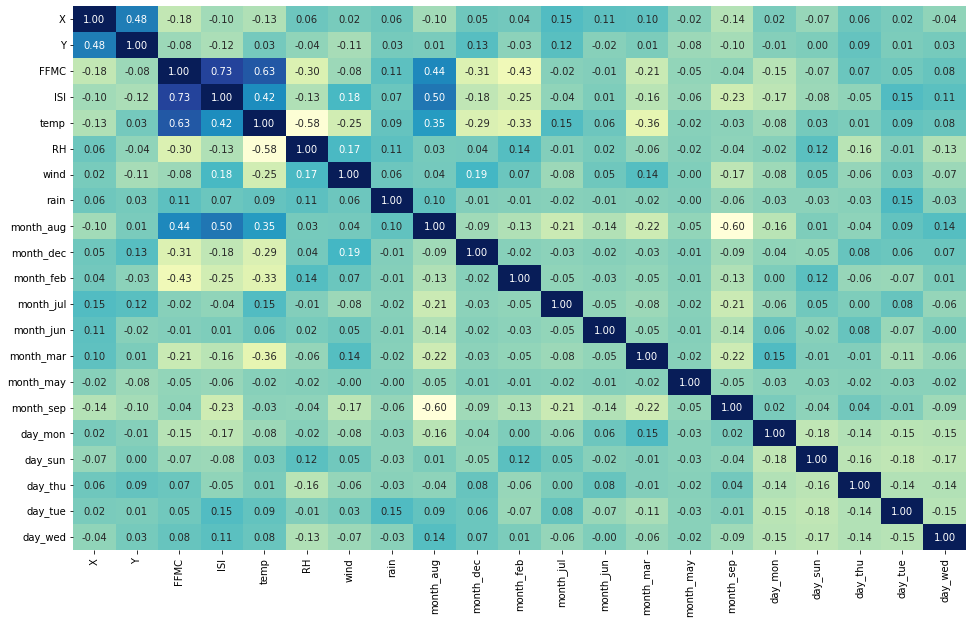

In [24]:
plt.figure(figsize =(16,10))

sns.heatmap(X.corr(),annot=True,cmap='YlGnBu',fmt=".2f",cbar=False)
plt.show()

# Modelo modificando el tiempo

Dado que estamos trabajando con tiempo (meses), hay que tener cuidado con la correlación. Para intentar arreglar esto vamos a dividir los meses entre aquellos en donde el clima es caliente (Junio, Julio, Agost y Septiembre) y aquellos en donde no.


Luego, vamos a procedes a eliminar la variable del día debido a que un incendio no tiene relación con qué día de la semana es.

In [25]:
forest_dummies = pd.read_csv('forest_data.txt', delim_whitespace=True)
forest_dummies.head()

#Los meses con calor van a valer 1 y los meses con frio valen 0
forest_dummies['month'] = np.where(forest_dummies['month'].isin(['jun', 'jul', 'aug', 'sep']), 1, 0)
forest_dummies.head()

#quitamos la columna del dia 
forest_dummies = forest_dummies.drop('day', axis=1)
forest_dummies.head()

,X,Y,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,9,9,1,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.36
1,1,4,1,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.43
2,2,5,1,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.47
3,1,2,1,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.55
4,8,6,1,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.61


In [26]:
#creamos un modelo con la variable respuesta ln
X = forest_dummies.drop('area', axis=1)
y = np.log(forest_dummies['area'])

#agregamos la columna de unos a la matriz X
X_cons = sm.add_constant(X)

#usamos regresion lineal multiple
model_dummies = sm.GLS(y, X_cons).fit()
model_dummies.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.053
Model:                            GLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.314
Date:                Sun, 04 Jun 2023   Prob (F-statistic):              0.217
Time:                        20:14:07   Log-Likelihood:                -489.50
No. Observations:                 270   AIC:                             1003.
Df Residuals:                     258   BIC:                             1046.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7784      3.684      0.211      0.833      -6.476       8.033
X              0.0290      0.046      0.634      0.526      -0.061       0.119
Y             -0.0808      0.093     -0.873      0.384      -0.263       0.102
month         -1.0549      0.512     -2.060      0.040      -2.063      -0.046
FFMC           0.0178      0.041      0.434      0.665      -0.063       0.099
DMC            0.0041      0.002      1.799      0.073      -0.000       0.009
DC             0.0005      0.001      0.655      0.513      -0.001       0.002
ISI           -0.0562      0.034     -1.635      0.103      -0.124       0.011
temp           0.0164      0.029      0.572      0.568      -0.040       0.073
RH            -0.0050      0.009     -0.578      0.563      -0.022       0.012
wind           0.0487      0.056      0.873      0.383      -0.061       0.159
rain           0.0314      0.240      0.131      0.896      -0.440       0.503
==============================================================================
Omnibus:                        7.435   Durbin-Watson:                   0.943
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.237
Skew:                           0.367   Prob(JB):                       0.0268
Kurtosis:                       3.324   Cond. No.                     2.53e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Vemos que el valor de la $R^2$ no mejoró. Veamos el análisis de residuales.

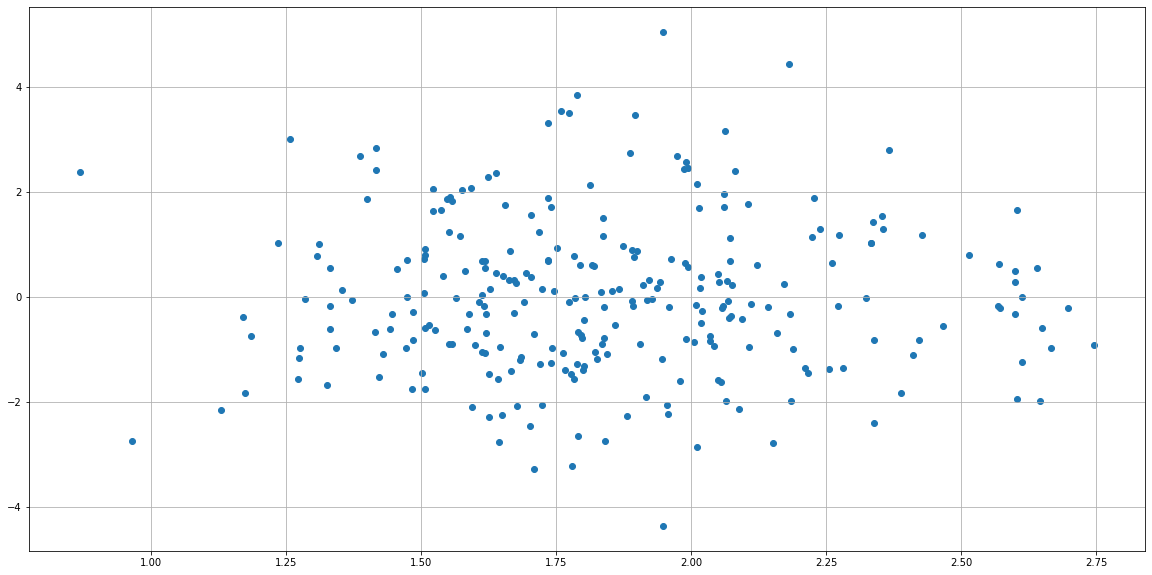

In [27]:
#hacemos el analisis de residuales
plt.figure(figsize=(20,10))
plt.scatter(np.matmul(model_dummies.model.exog, model_dummies.params), model_dummies.resid)
plt.grid()

In [28]:
#prueba de Goldfeld-Quandt
result = sm.stats.diagnostic.het_goldfeldquandt(model_dummies.model.endog, model_dummies.model.exog, alternative="two-sided")

if result[1] > 0.05:
    print("No rechazamos H_0: la varianza es constante\n")
else:
    print("Rechazamos H_0: la varianza no es constante\n")

No rechazamos H_0: la varianza es constante



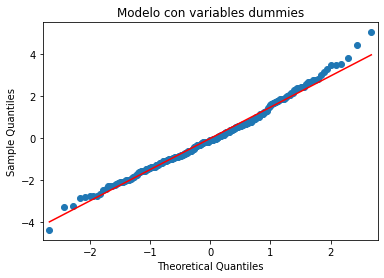

In [29]:
# Normalidad de los residuos usando qqplot
sm.qqplot(model_dummies.resid, line='s')
plt.title('Modelo con variables dummies')
plt.show()


In [30]:
#usando shapiro
print(f'El p-valor de la prueba es: {stats.shapiro(model_dummies.resid)[1]}')
if stats.shapiro(model_dummies.resid)[1] > 0.05:
    print("No rechazamos H_0: los residuos tienen distribución normal")
else:
    print("Rechazamos H_0: los residuos no tienen distribución normal")
print('--------------------------------------------------\n')


El p-valor de la prueba es: 0.06866171956062317
No rechazamos H_0: los residuos tienen distribución normal
--------------------------------------------------



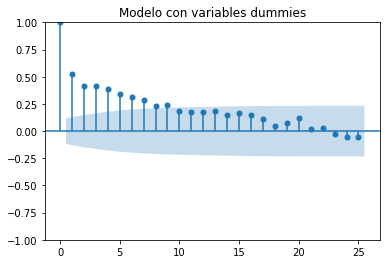

In [31]:
# autocorrelograma
plot_acf(model_dummies.resid)
plt.title('Modelo con variables dummies')
plt.show()

In [32]:
#prueba de Durbin-Watson
print(f'El valor de la prueba es: {sm.stats.stattools.durbin_watson(model_dummies.resid)}')
if sm.stats.stattools.durbin_watson(model_dummies.resid) > 1.5:
    print("No rechazamos H_0: no hay correlación serial")
else:
    print("Rechazamos H_0: hay correlación")
print('--------------------------------------------------\n')

El valor de la prueba es: 0.9430689473069495
Rechazamos H_0: hay correlación
--------------------------------------------------



Vemos que seguimos teniendo problemas con la correlación.

In [33]:
#checamos la multicolinealidad
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X_cons.values, i) for i in range(X_cons.shape[1])]
vif['features'] = X_cons.columns
vif.round(1)

,VIF Factor,features
0,1592.3,const
1,1.4,X
2,1.4,Y
3,4.5,month
4,2.7,FFMC
5,2.4,DMC
6,3.2,DC
7,2.4,ISI
8,3.7,temp
9,2.0,RH


Dado que todos los valores VIF son menores que 5, enotnces afirmamos que no hay multicolinealidad.

# Modelo que dice si el incendio es grave o no 

Vamos a hacer una modificación del modelo con el objetivo de mejorarlo. Ahora en lugar de predecir el tamaño del área afectada, vamos a elegir un umbral y si el incendio rebasa dicho valor entonces diremos que fue grave y le asignaremos un 1. En caso contrario se asignará un 0


Como estamos en un problema de clasificación binaria entonces vamos a usar un modelo de regresión logística cuya formula es:

$$\frac{1}{1-\exp^{-(\beta_0  + \sum_{i = 1}^{n}\beta_i X_i)}}$$


Vemos que el exponente es una regresión lineal múltiple. 

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

#dividimos los incendios entre graves y no graves a partir de un umbral 
logistic = forest_dummies.copy()

logistic_models = {}
umbrales = [2.5*i for i in range(1, 10)]
accuracy_list = []


#creamos diferentes modelos segun el umbral
for i in range(len(umbrales)):
    logistic['area'] = np.where(forest_dummies['area'] > umbrales[i], 1, 0)
    X = logistic.drop('area', axis=1)
    y = logistic['area']

    log_reg = LogisticRegression()
    log_reg.fit(X, y)
    logistic_models[umbrales[i]] = log_reg

#imprimimos los resultados
for i in range(len(umbrales)):
    print(f'Umbral: {umbrales[i]}')

    print('Matriz de confusión')
    print(confusion_matrix(y, logistic_models[umbrales[i]].predict(X)))

    #guardamos el accuracy 
    accuracy_list.append(logistic_models[umbrales[i]].score(X, y))
    print('--------------------------------------------------\n')



C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Umbral: 2.5
Matriz de confusión
[[  8 205]
 [  4  53]]
--------------------------------------------------

Umbral: 5.0
Matriz de confusión
[[ 67 146]
 [ 15  42]]
--------------------------------------------------

Umbral: 7.5
Matriz de confusión
[[179  34]
 [ 45  12]]
--------------------------------------------------

Umbral: 10.0
Matriz de confusión
[[199  14]
 [ 52   5]]
--------------------------------------------------

Umbral: 12.5
Matriz de confusión
[[213   0]
 [ 57   0]]
--------------------------------------------------

Umbral: 15.0
Matriz de confusión
[[212   1]
 [ 57   0]]
--------------------------------------------------

Umbral: 17.5
Matriz de confusión
[[210   3]
 [ 57   0]]
--------------------------------------------------

Umbral: 20.0
Matriz de confusión
[[213   0]
 [ 57   0]]
--------------------------------------------------

Umbral: 22.5
Matriz de confusión
[[213   0]
 [ 57   0]]
--------------------------------------------------



C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

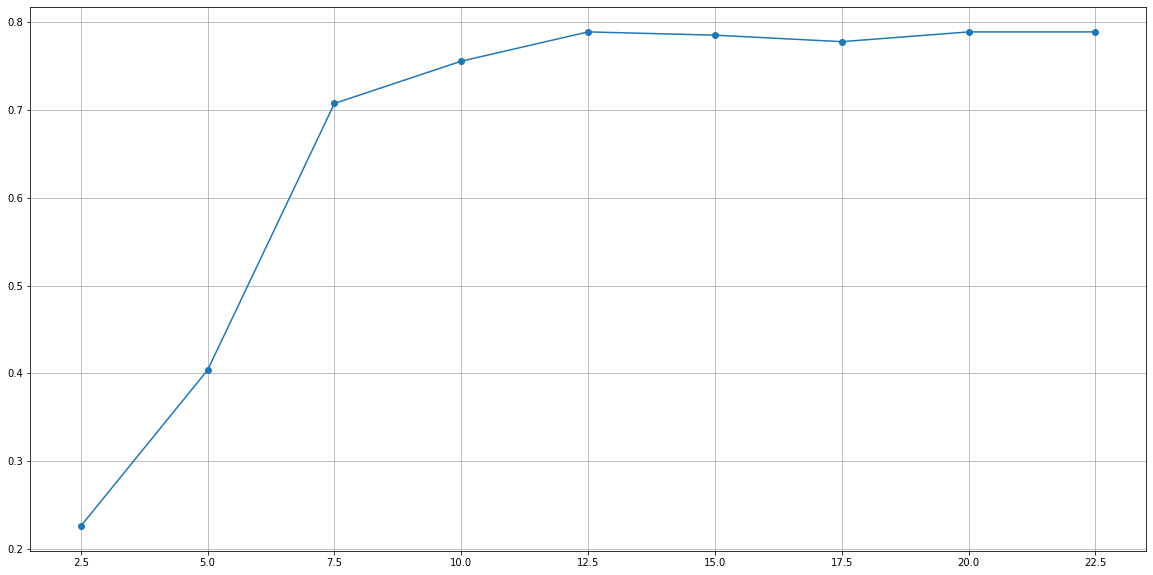

In [35]:
#creamos un dataframe con los umbrales y accuracy
accuracy_df = pd.DataFrame()

accuracy_df['Umbral'] = umbrales
accuracy_df['Accuracy'] = accuracy_list

#graficamos el accuracy
plt.figure(figsize=(20,10))
plt.plot(accuracy_df['Umbral'], accuracy_df['Accuracy'], marker='o')
plt.grid()


In [36]:
#tomamos el modelo con un umbral de 7.5
model_logistic = logistic_models[7.5]

#imprimimos los resultados
print('Modelo de regresión logística')
print('Matriz de confusión')
print(confusion_matrix(y, model_logistic.predict(X)))
print('--------------------------------------------------\n')

print('Reporte de clasificación')
print(classification_report(y, model_logistic.predict(X)))
print('--------------------------------------------------\n')

print('Accuracy')
print(model_logistic.score(X, y))
print('--------------------------------------------------\n')


Modelo de regresión logística
Matriz de confusión
[[179  34]
 [ 45  12]]
--------------------------------------------------

Reporte de clasificación
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       213
           1       0.26      0.21      0.23        57

    accuracy                           0.71       270
   macro avg       0.53      0.53      0.53       270
weighted avg       0.69      0.71      0.70       270

--------------------------------------------------

Accuracy
0.7074074074074074
--------------------------------------------------



# Modelo para meses calurosos

El objetivo de esta sección es crear dos modelos, uno para la época de calor y otra para el resto de meses

In [37]:
#creamos diferentes modelos segun el umbral
for i in range(len(umbrales)):
    logistic['area'] = np.where(forest_dummies['area'] > umbrales[i], 1, 0)
    X = logistic.drop('area', axis=1)
    y = logistic['area']

    log_reg = LogisticRegression()
    log_reg.fit(X, y)
    logistic_models[umbrales[i]] = log_reg

C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [38]:
calor = forest_dummies.copy()

#seleccionamos los meses de calor
calor = calor[calor['month'] == 1]

#hacemos regresion logistica para diferentes umbrales
calor_models = {}
umbrales = [2.5*i for i in range(1, 10)]
accuracy_list = []

for i in range(len(umbrales)):
    calor_log = calor.copy()
    calor_log['area'] = np.where(calor['area'] > umbrales[i], 1, 0)
    X = calor_log.drop('area', axis=1)
    y = calor_log['area']

    log_reg = LogisticRegression()
    log_reg.fit(X, y)

    calor_models[umbrales[i]] = log_reg

#imprimimos los resultados
for i in range(len(umbrales)):
    print(f'Umbral: {umbrales[i]}')

    print('Matriz de confusión')
    print(confusion_matrix(y, calor_models[umbrales[i]].predict(X)))
    accuracy_calor = calor_models[umbrales[i]].score(X, y)
    print(f'Accuracy {accuracy_calor}')

    #guardamos el accuracy 
    accuracy_list.append(accuracy_calor)
    print('--------------------------------------------------\n')

    

C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Umbral: 2.5
Matriz de confusión
[[  8 169]
 [  4  41]]
Accuracy 0.22072072072072071
--------------------------------------------------

Umbral: 5.0
Matriz de confusión
[[81 96]
 [19 26]]
Accuracy 0.481981981981982
--------------------------------------------------

Umbral: 7.5
Matriz de confusión
[[161  16]
 [ 39   6]]
Accuracy 0.7522522522522522
--------------------------------------------------

Umbral: 10.0
Matriz de confusión
[[168   9]
 [ 43   2]]
Accuracy 0.7657657657657657
--------------------------------------------------

Umbral: 12.5
Matriz de confusión
[[177   0]
 [ 45   0]]
Accuracy 0.7972972972972973
--------------------------------------------------

Umbral: 15.0
Matriz de confusión
[[177   0]
 [ 45   0]]
Accuracy 0.7972972972972973
--------------------------------------------------

Umbral: 17.5
Matriz de confusión
[[177   0]
 [ 45   0]]
Accuracy 0.7972972972972973
--------------------------------------------------

Umbral: 20.0
Matriz de confusión
[[177   0]
 [ 45   0]]

C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


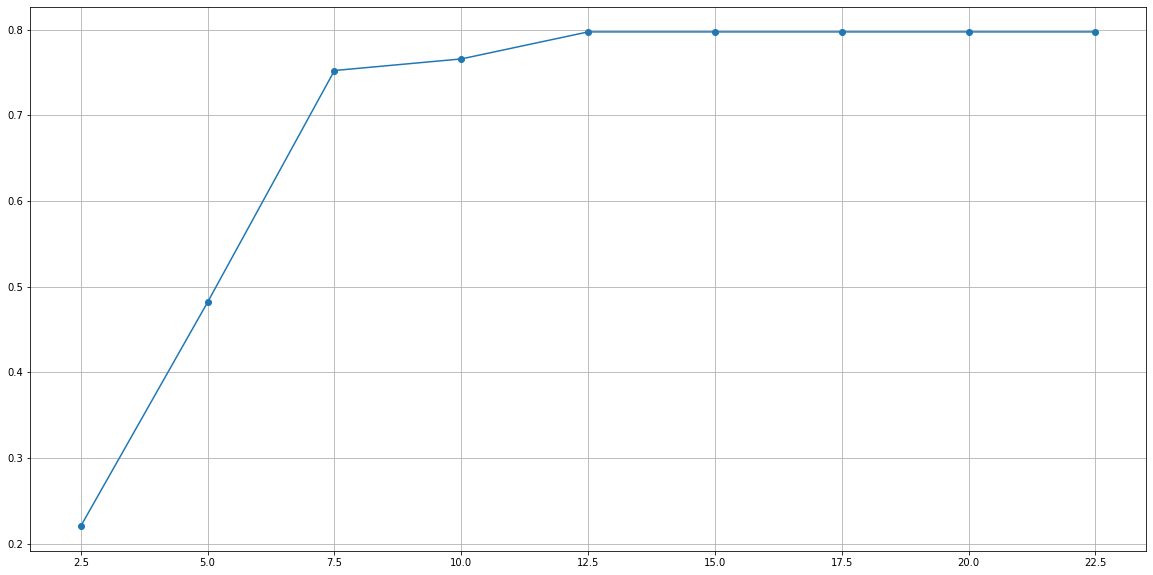

In [39]:
#creamos un dataframe con los umbrales y accuracy
accuracy_df = pd.DataFrame()

accuracy_df['Umbral'] = umbrales
accuracy_df['Accuracy'] = accuracy_list

#graficamos el accuracy
plt.figure(figsize=(20,10))
plt.plot(accuracy_df['Umbral'], accuracy_df['Accuracy'], marker='o')
plt.grid()


In [40]:
#tomamos el modelo con un umbral de 7.5
model_logistic = calor_models[7.5]

#imprimimos los resultados
print('Modelo de regresión logística')
print('Matriz de confusión')
print(confusion_matrix(y, model_logistic.predict(X)))
print('--------------------------------------------------\n')

print('Reporte de clasificación')
print(classification_report(y, model_logistic.predict(X)))
print('--------------------------------------------------\n')


Modelo de regresión logística
Matriz de confusión
[[161  16]
 [ 39   6]]
--------------------------------------------------

Reporte de clasificación
              precision    recall  f1-score   support

           0       0.81      0.91      0.85       177
           1       0.27      0.13      0.18        45

    accuracy                           0.75       222
   macro avg       0.54      0.52      0.52       222
weighted avg       0.70      0.75      0.72       222

--------------------------------------------------



In [41]:
#ahora con los meses de frio
frio = forest_dummies.copy()

#seleccionamos los meses de frio
frio = frio[frio['month'] == 0]

#hacemos regresion logistica para diferentes umbrales
frio_models = {}
umbrales = [2.5*i for i in range(1, 10)]
accuracy_list = []

for i in range(len(umbrales)):
    frio_log = frio.copy()
    frio_log['area'] = np.where(frio['area'] > umbrales[i], 1, 0)
    X = frio_log.drop('area', axis=1)
    y = frio_log['area']

    log_reg = LogisticRegression()
    log_reg.fit(X, y)

    frio_models[umbrales[i]] = log_reg

#imprimimos los resultados
for i in range(len(umbrales)):
    print(f'Umbral: {umbrales[i]}')

    print('Matriz de confusión')
    print(confusion_matrix(y, frio_models[umbrales[i]].predict(X)))
    accuracy_frio = frio_models[umbrales[i]].score(X, y)
    print(f'Accuracy {accuracy_frio}')

    #guardamos el accuracy 
    accuracy_list.append(accuracy_frio)
    print('--------------------------------------------------\n')

Umbral: 2.5
Matriz de confusión
[[ 1 35]
 [ 1 11]]
Accuracy 0.25
--------------------------------------------------

Umbral: 5.0
Matriz de confusión
[[ 6 30]
 [ 3  9]]
Accuracy 0.3125
--------------------------------------------------

Umbral: 7.5
Matriz de confusión
[[16 20]
 [ 5  7]]
Accuracy 0.4791666666666667
--------------------------------------------------

Umbral: 10.0
Matriz de confusión
[[27  9]
 [ 6  6]]
Accuracy 0.6875
--------------------------------------------------

Umbral: 12.5
Matriz de confusión
[[30  6]
 [ 7  5]]
Accuracy 0.7291666666666666
--------------------------------------------------

Umbral: 15.0
Matriz de confusión
[[31  5]
 [ 6  6]]
Accuracy 0.7708333333333334
--------------------------------------------------

Umbral: 17.5
Matriz de confusión
[[31  5]
 [ 6  6]]
Accuracy 0.7708333333333334
--------------------------------------------------

Umbral: 20.0
Matriz de confusión
[[35  1]
 [ 7  5]]
Accuracy 0.8333333333333334
-------------------------------------

C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

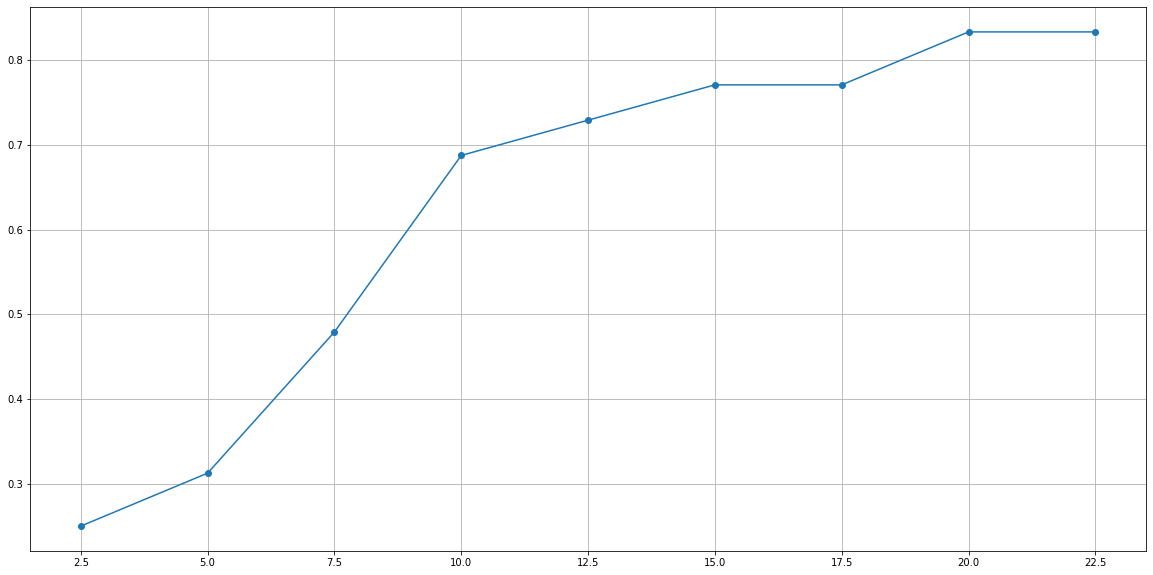

In [42]:
#creamos un dataframe con los umbrales y accuracy
accuracy_df = pd.DataFrame()

accuracy_df['Umbral'] = umbrales
accuracy_df['Accuracy'] = accuracy_list

#graficamos el accuracy
plt.figure(figsize=(20,10))
plt.plot(accuracy_df['Umbral'], accuracy_df['Accuracy'], marker='o')
plt.grid()


In [43]:
#tomamos el modelo con el umbral de 15
model_logistic = logistic_models[15]

#imprimimos los resultados
print('Modelo de regresión logística')
print('Matriz de confusión')
print(confusion_matrix(y, model_logistic.predict(X)))
print('--------------------------------------------------\n')

print('Reporte de clasificación')
print(classification_report(y, model_logistic.predict(X)))
print('--------------------------------------------------\n')

print('Accuracy')
print(model_logistic.score(X, y))
print('--------------------------------------------------\n')



Modelo de regresión logística
Matriz de confusión
[[36  0]
 [12  0]]
--------------------------------------------------

Reporte de clasificación
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        36
           1       0.00      0.00      0.00        12

    accuracy                           0.75        48
   macro avg       0.38      0.50      0.43        48
weighted avg       0.56      0.75      0.64        48

--------------------------------------------------

Accuracy
0.75
--------------------------------------------------



C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
